In [2]:
%load_ext autoreload
%autoreload 2

In [37]:
from datetime import datetime
import os
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import torch
import xarray
import pandas as pd
from dataset.dataset import ImageDataset, SingleImageDataset, pickle_write, pickle_read
from dataset.station_dataset import GroundstationDataset, GroundstationDataset2
from dataset.normalization import ZeroMinMax
from tqdm import tqdm
from utils.plotting import prediction_error_plot, plot_station_scatter
from cartopy.mpl.gridliner import (
    LongitudeFormatter,
    LatitudeFormatter,
    LongitudeLocator,
    LatitudeLocator,
)

import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rc('axes', labelsize=20, titlesize=25) 


FIGSIZE=(13.33,7.5)
DPI=300

# List DL models

In [4]:

model_folders = {
    'wv1ykh5d':'../train/SIS_point_estimation/wv1ykh5d/', # SARAH3 emulator
    '1otg6d0w':'../train/SIS_point_estimation_groundstation/1otg6d0w/', #  trained on 80 DWD groundstations
    '4krccmyz':'../train/SIS_point_estimation_groundstation/4krccmyz/', # retrained on SARAH3 dataset for bias
}

# Baseline predictions

In [17]:
# BSRN
baseline_BSRN = pickle_read('/scratch/snx3000/kschuurm/irradiance_estimation/inference/BSRN_baseline_predictions.pkl')
#KNMI
knmi_fns = glob('/scratch/snx3000/kschuurm/irradiance_estimation/inference/KNMI/baseline_predictions_*.pkl')
baseline_knmi = {os.path.basename(fn).split('predictions_')[-1].replace('.pkl',''): pickle_read(fn) for fn in knmi_fns}

#KNMI
dwd_fns = glob('/scratch/snx3000/kschuurm/irradiance_estimation/inference/DWD/baseline_predictions_*.pkl')
baseline_dwd = {os.path.basename(fn).split('predictions_')[-1].replace('.pkl',''): pickle_read(fn) for fn in dwd_fns}


train_id = [15000, 2638, 662, 342, 691, 4104, 1684, 5426, 1766, 3167, 596, 880, 1346, 4271, 1550, 3196, 5792, 2485, 856, 1468, 3287, 4336, 701, 3126, 891, 1078, 4393, 963, 5705, 5546, 7368, 4887, 164, 704, 2261, 656, 2559, 6197, 3513, 3032, 7351, 430, 1443, 2907, 5856, 5404, 6163, 2483, 3268, 2601, 15444, 13674, 7374, 5480, 7367, 4745, 2014, 4625, 5100, 3761, 460, 7369, 3086, 3366, 282, 591, 1639, 232, 4177, 7370, 2667, 4928, 2712, 4466, 5397, 5516, 1975, 1503, 2115, 1605]
valid_id = [1757, 5109, 953, 3028, 2290, 5906, 2171, 427, 2932, 2812, 5839, 1691, 3811, 1420, 5142, 4911, 3660, 3730, 1048]
train_id = [str(i) for i in train_id]
valid_id = [str(i) for i in valid_id]

baseline_dwd_train = {k:v for k,v in baseline_dwd.items() if k in train_id}
baseline_dwd_valid = {k:v for k,v in baseline_dwd.items() if k in valid_id}

baseline_prediction = {'BSRN':baseline_BSRN,  'DWD train':baseline_dwd_train, 'DWD valid':baseline_dwd_valid, 'KNMI':baseline_knmi}

# Model predictions

In [6]:
minmax = ZeroMinMax()

model_predictions = {}

for model_nm, fol in model_folders.items():
    inference_fn = fol + 'inference/'
    
    bsrn_pred = pickle_read(inference_fn + 'BSRN_predictions.pkl')
    dwd_train = pickle_read(inference_fn + 'DWD_train_predictions.pkl')
    dwd_valid = pickle_read(inference_fn + 'DWD_valid_predictions.pkl')
    knmi = pickle_read(inference_fn + 'KNMI_predictions.pkl')
    
    for pred in [bsrn_pred, dwd_train, dwd_valid, knmi]:
        for d in pred.values():
            d['y_hat'] = minmax.inverse(d['y_hat'].cpu(), ['SIS'])
            d['y'] = minmax.inverse(d['y'].cpu(), ['SIS'])
        
        
    model_predictions[model_nm] = {'BSRN':bsrn_pred, 
                                   'DWD train':dwd_train, 
                                   'DWD valid':dwd_valid, 
                                   'KNMI':knmi}


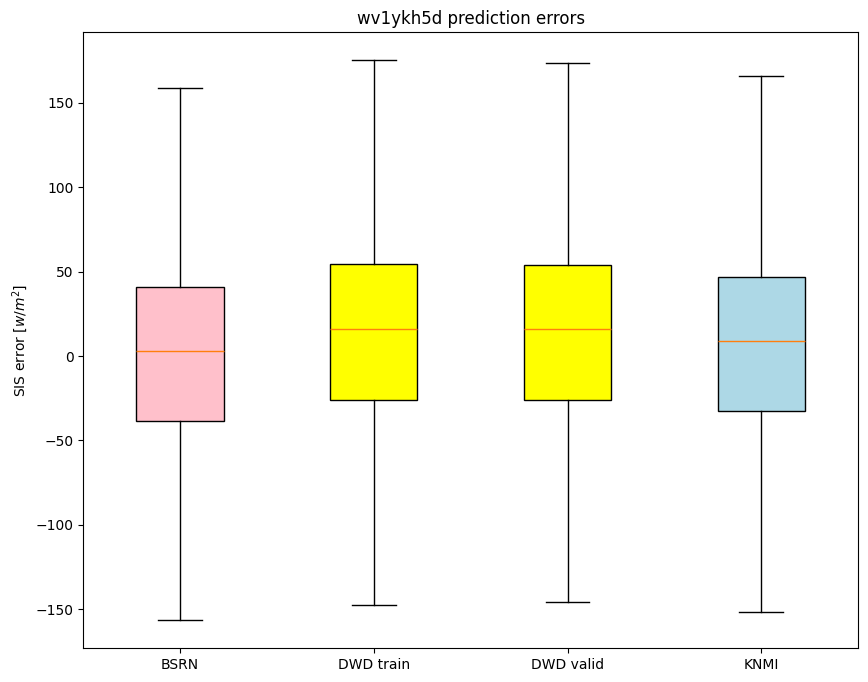

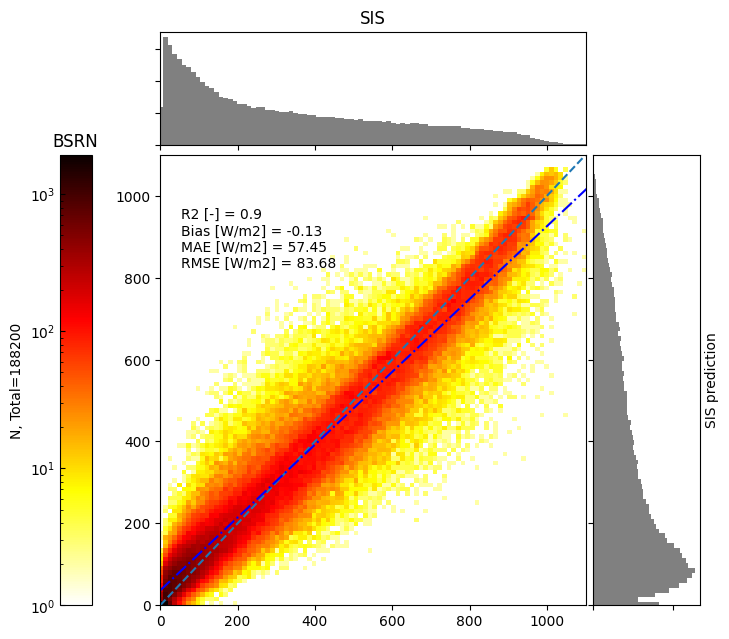

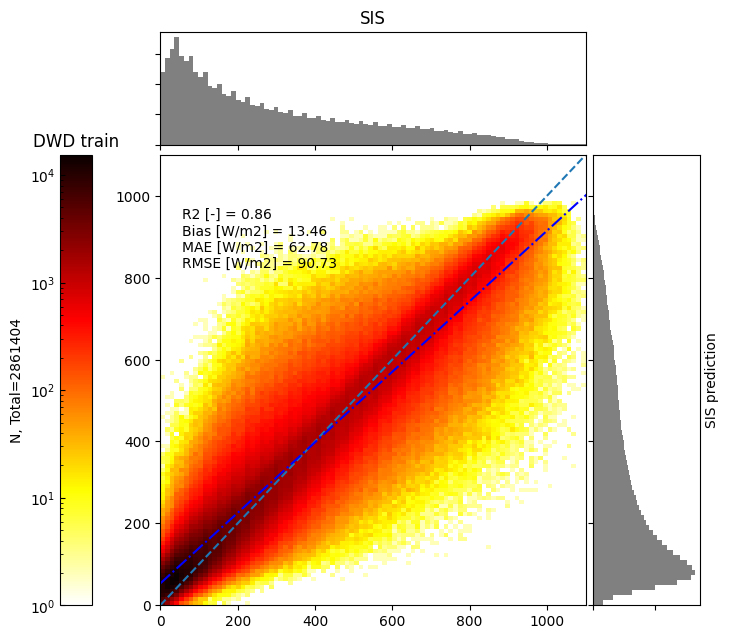

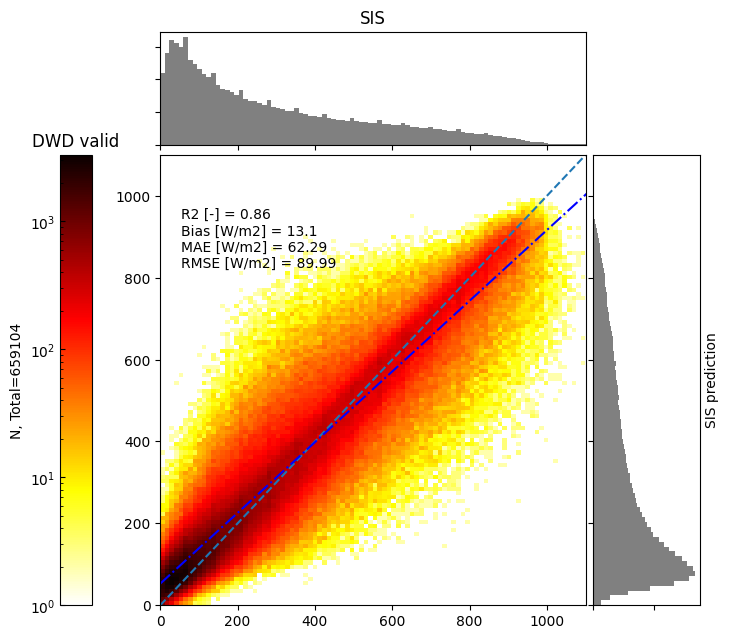

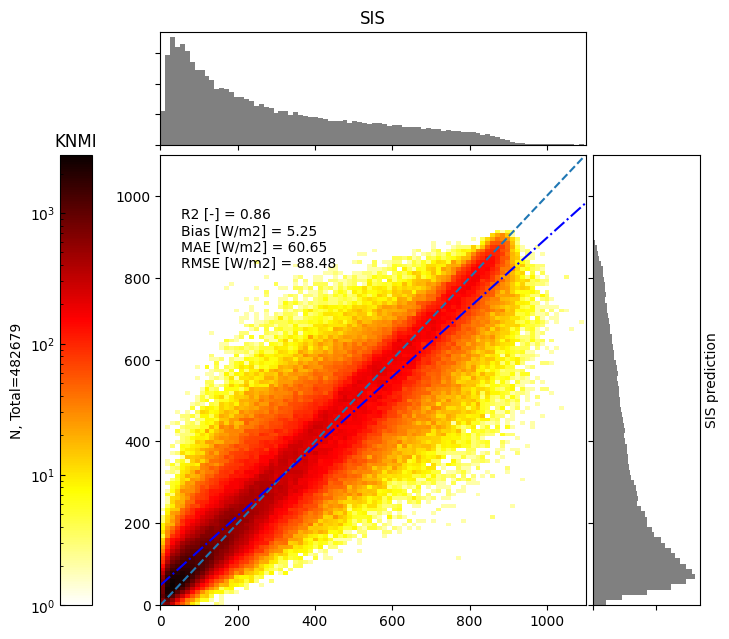

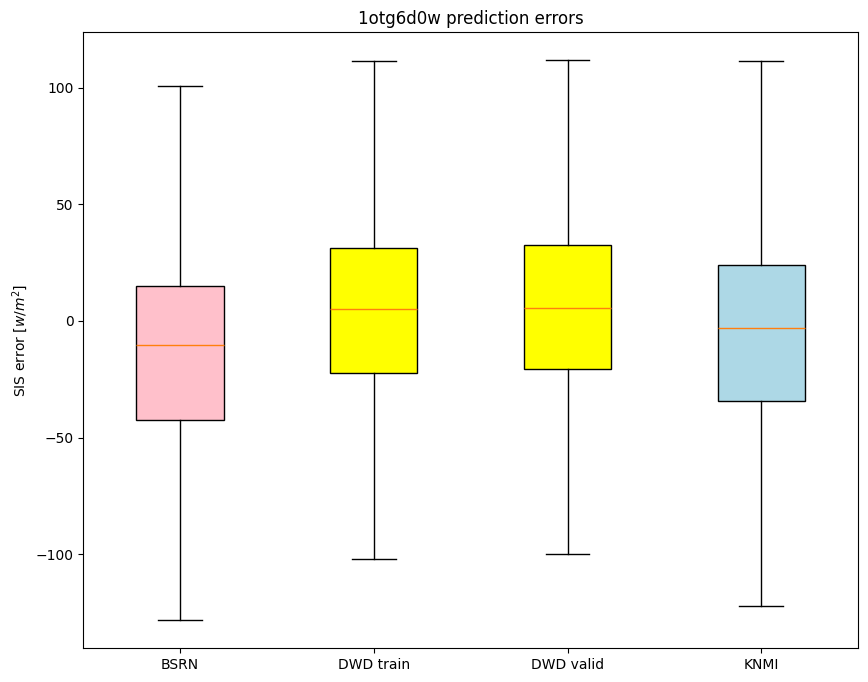

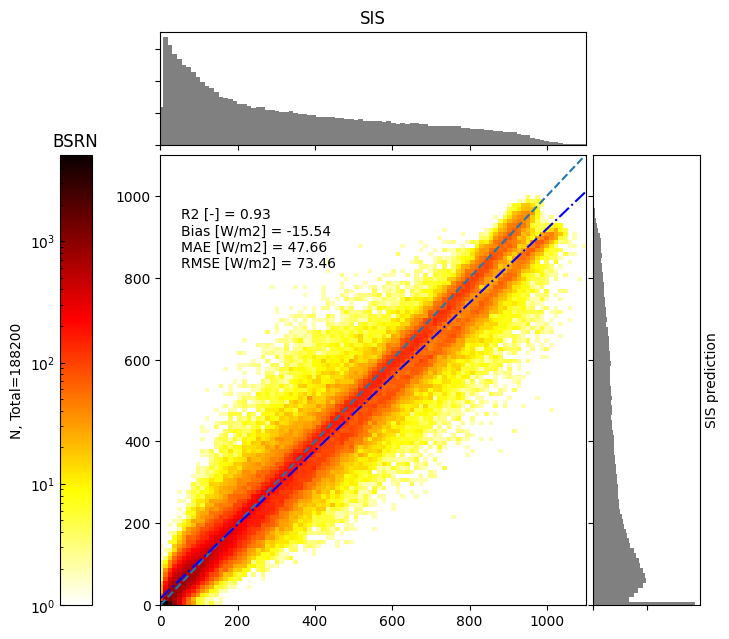

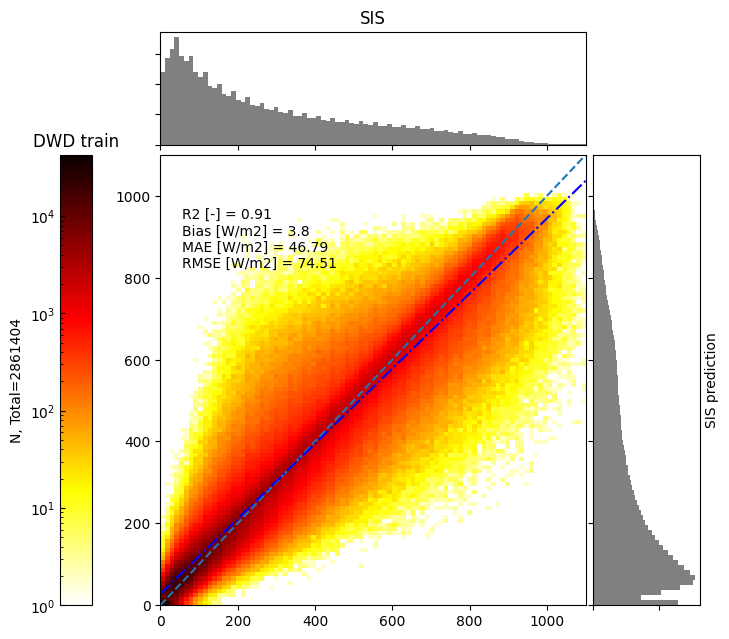

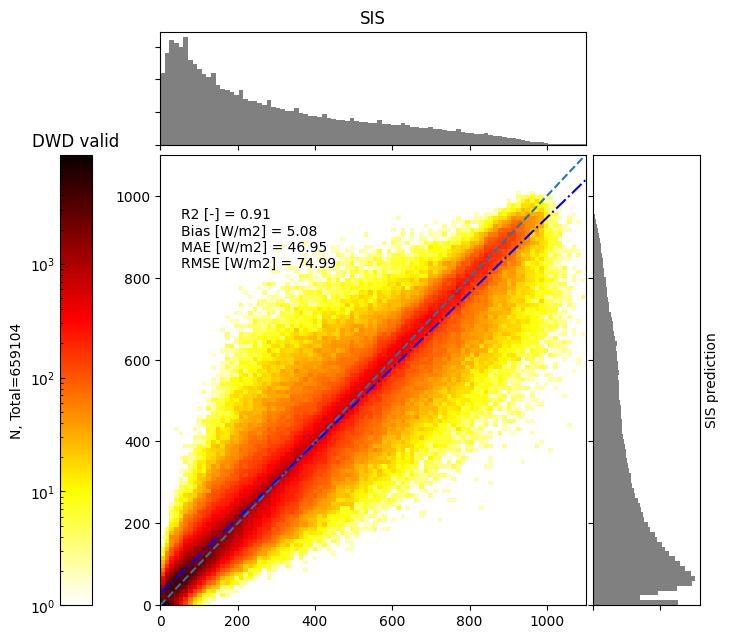

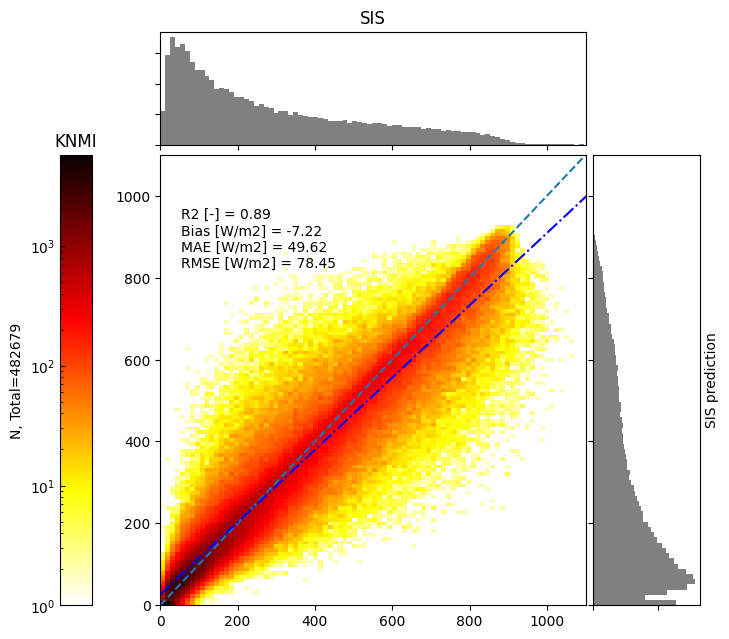

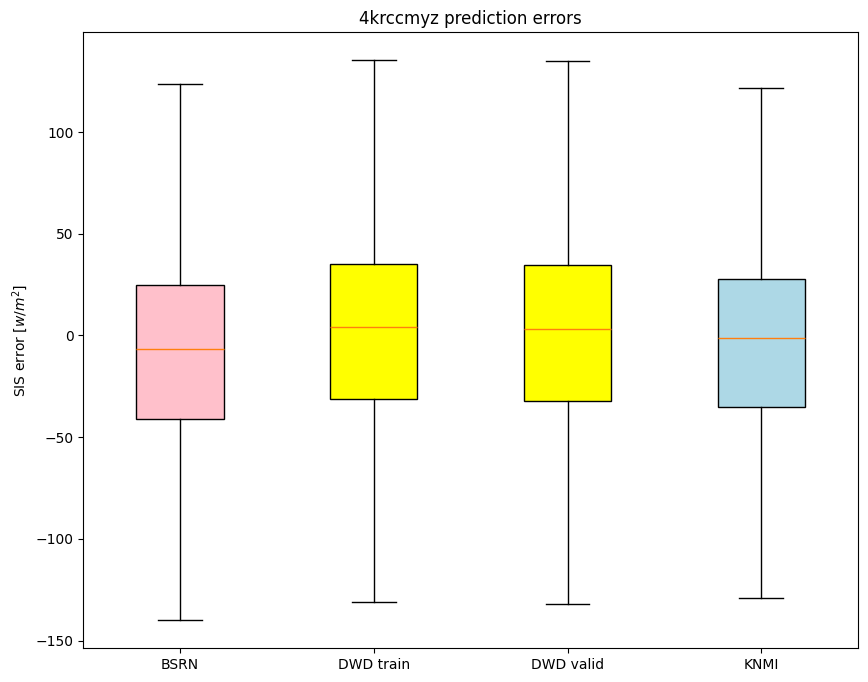

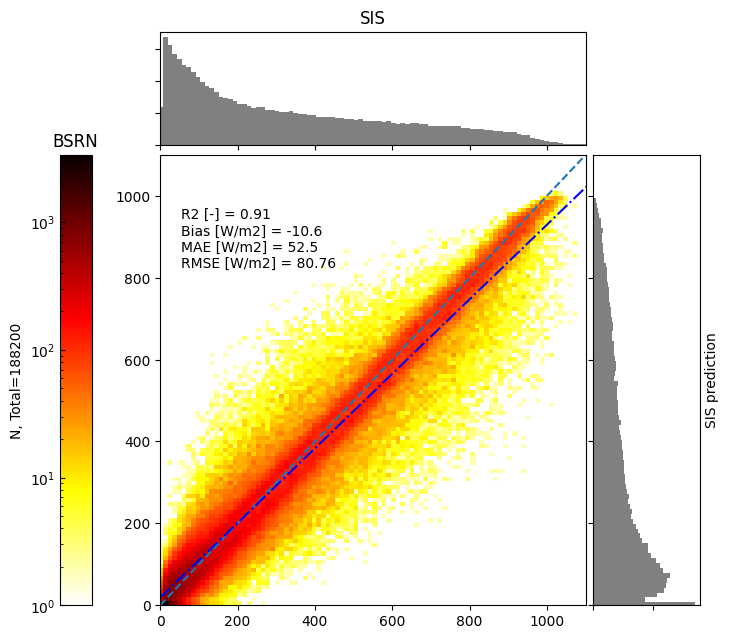

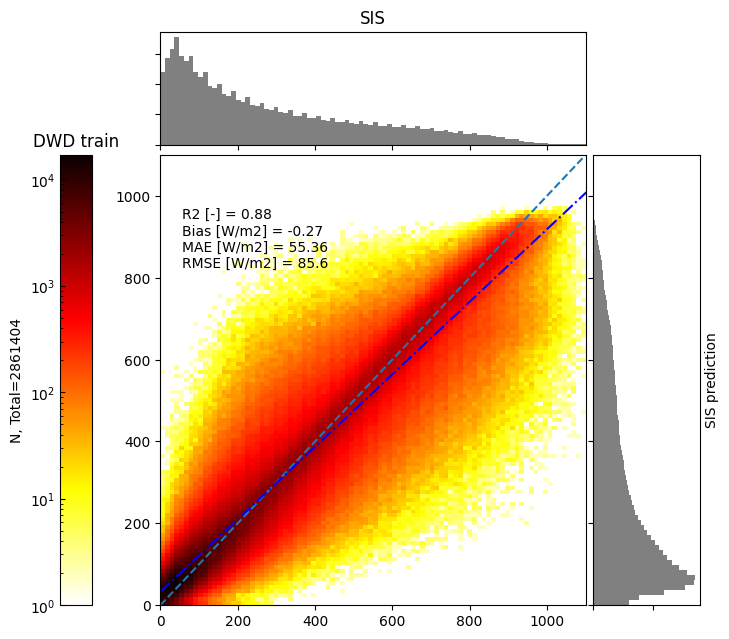

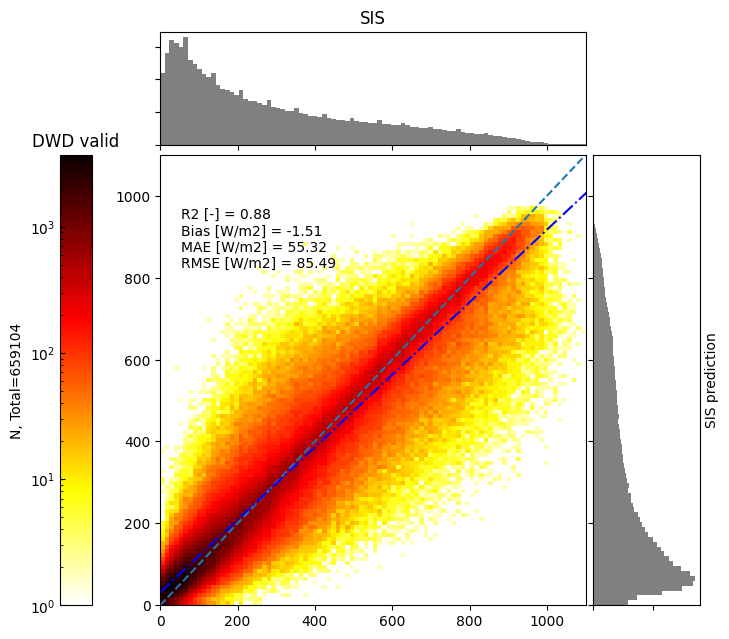

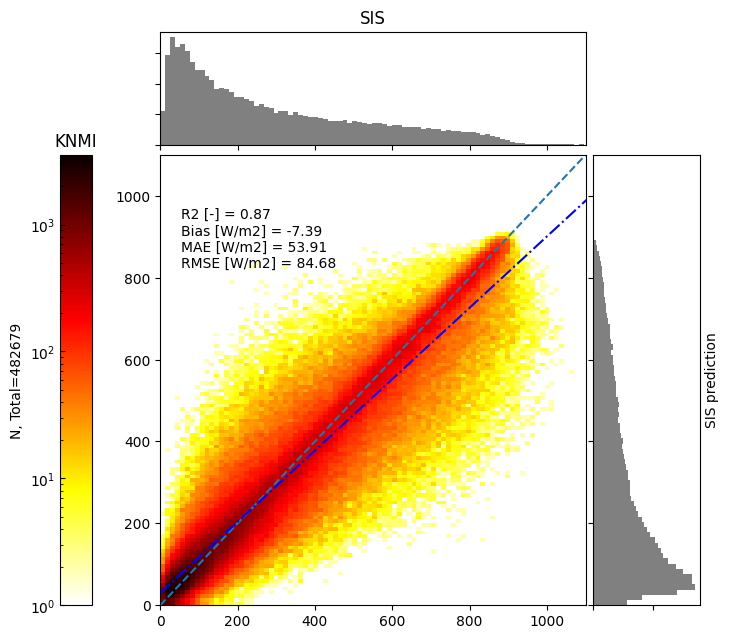

In [7]:
for model_nm, predictions in model_predictions.items():
    
    fig, axes = plt.subplots(1,1, figsize=(10,8))

    errors = {}
    for nm, pred_set in predictions.items():
        y = np.concatenate([p['y'].squeeze() for p in pred_set.values()])
        y_hat = np.concatenate([p['y_hat'].squeeze() for p in pred_set.values()])
        
        notnan = ~np.isnan(y_hat)
        y=y[notnan]
        y_hat=y_hat[notnan]
        
        errors[nm] = y_hat - y
        prediction_error_plot(y, y_hat, title=f'{nm}')
    
    bplot1 = axes.boxplot(errors.values(), 
                          labels= errors.keys(), 
                          sym='',
                         patch_artist=True,  # fill with color
                         )

    axes.set_title(f'{model_nm} prediction errors')
    axes.set_ylabel('SIS error $[w/m^2]$')

    colors = ['pink', 'yellow', 'yellow', 'lightblue']
    for bplot in (bplot1,):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)


In [ ]:
# Full error prediction plot

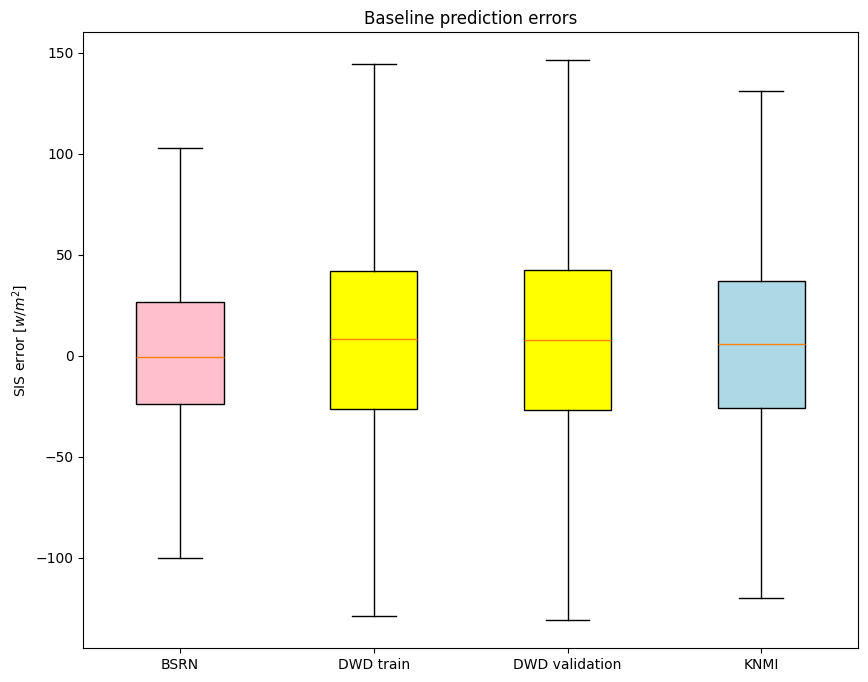

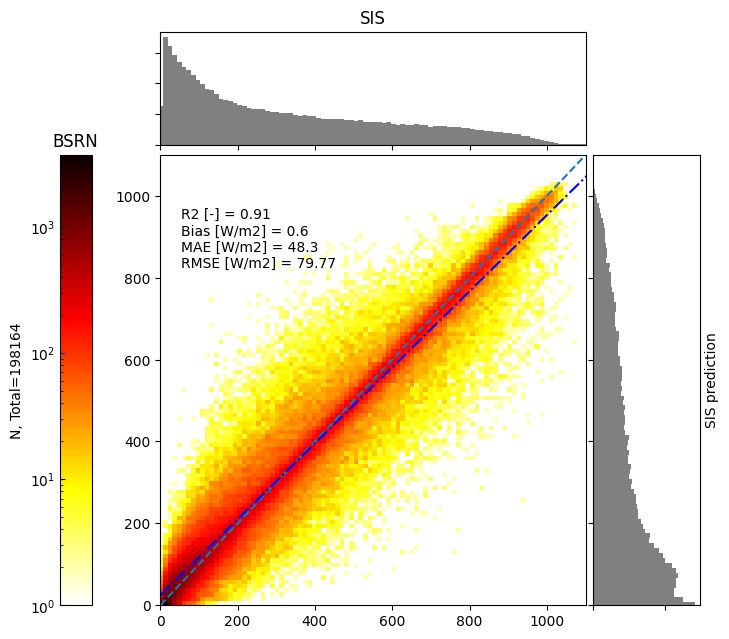

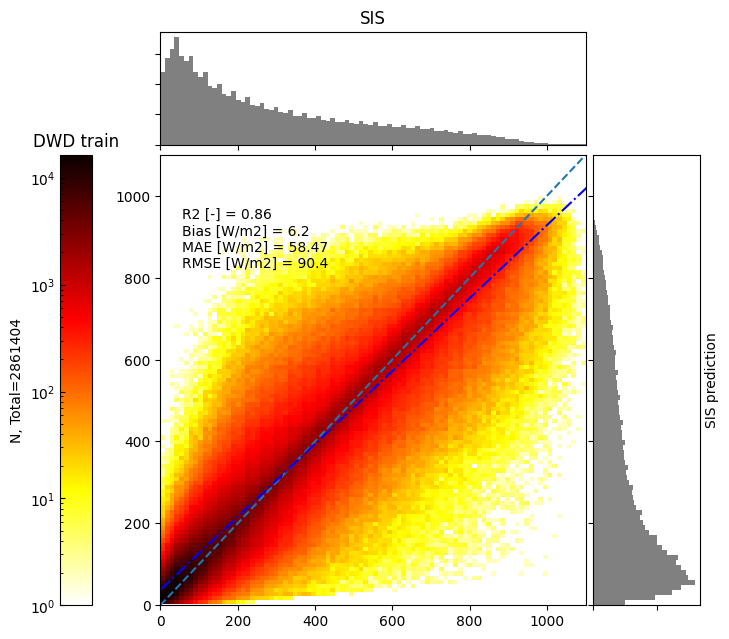

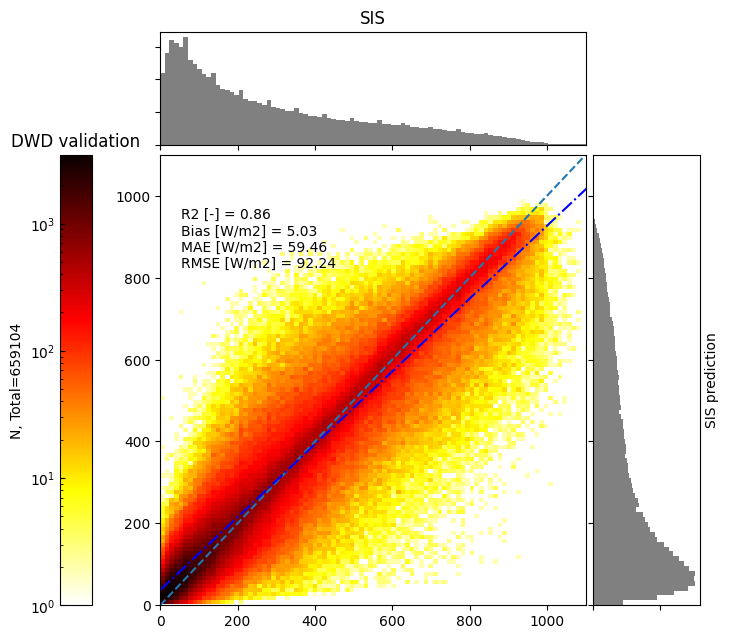

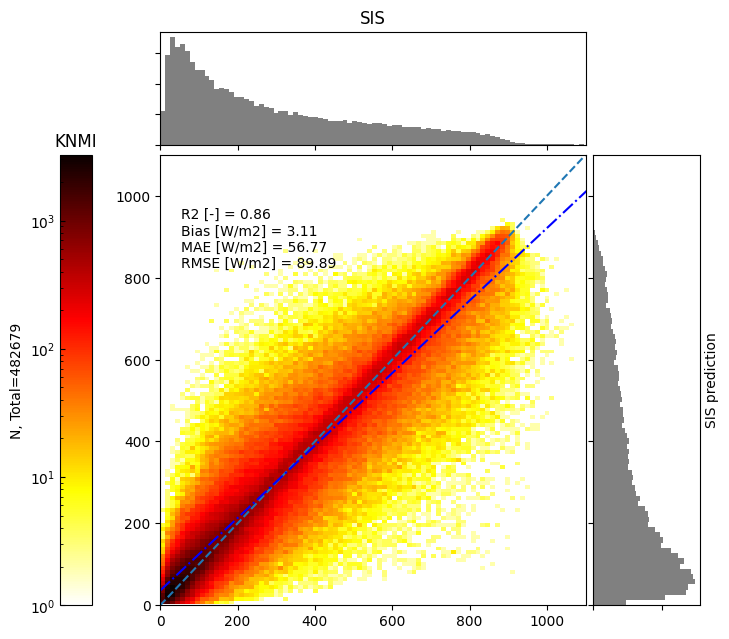

In [71]:
fig, axes = plt.subplots(1,1, figsize=FIGSIZE, dpi=DPI)

errors = {}
for baseline_nm, baseline_pred in baseline_prediction.items():
    y = np.concatenate([pred['y'] for pred in baseline_pred.values()])
    y_hat = np.concatenate([pred['y_hat'] for pred in baseline_pred.values()])
    
    errors[baseline_nm] = y_hat - y
    # prediction_error_plot(y, y_hat, title=f'{baseline_nm}')

bplot1 = axes.boxplot(errors.values(), 
                      labels= errors.keys(), 
                      sym='',
                     patch_artist=True,  # fill with color
                     )
                      
axes.set_title('Baseline prediction errors')
axes.set_ylabel('SIS error $[w/m^2]$')

colors = ['pink', 'yellow', 'yellow', 'lightblue']
for bplot in (bplot1,):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)



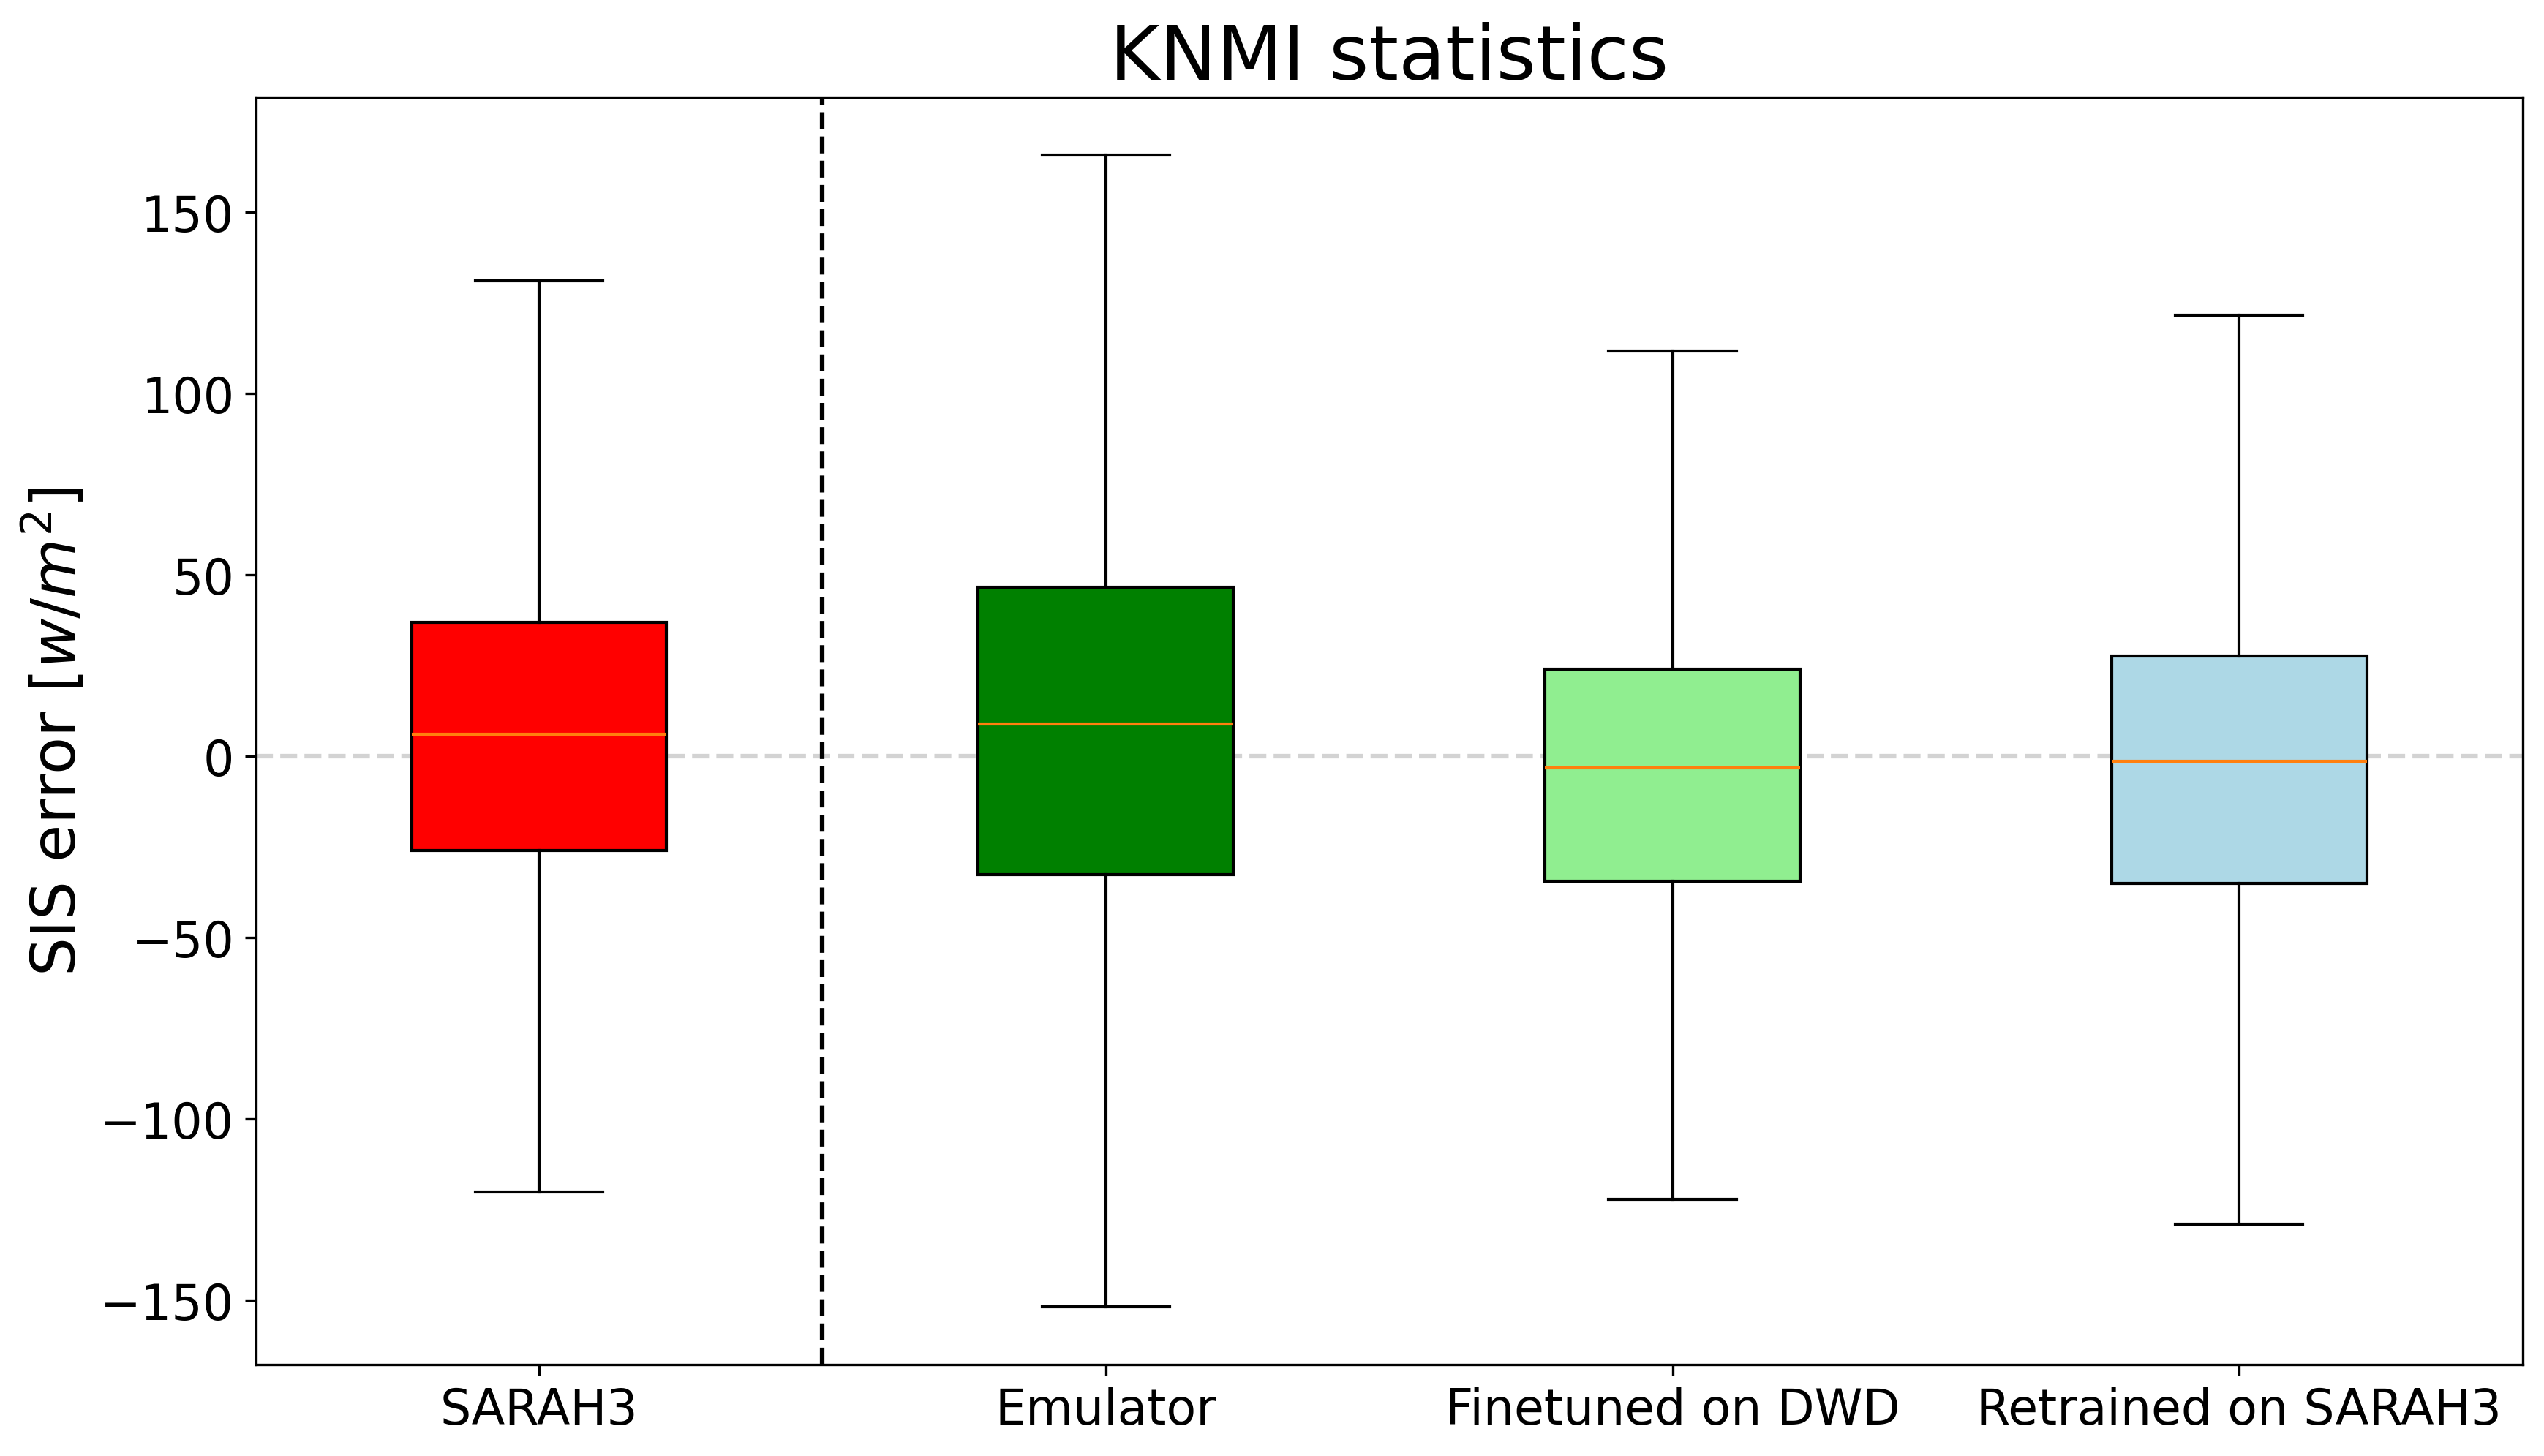

In [46]:

pyranometer_set = 'KNMI'

fig, axes = plt.subplots(1,1, figsize=FIGSIZE, dpi=DPI)

errors = {}
baseline_pred = baseline_prediction[pyranometer_set]
y = np.concatenate([pred['y'] for pred in baseline_pred.values()])
y_hat = np.concatenate([pred['y_hat'] for pred in baseline_pred.values()])

errors['SARAH3'] = y_hat - y

trans = {'wv1ykh5d':'Emulator', # SARAH3 emulator
    '1otg6d0w':'Finetuned on DWD', #  trained on 80 DWD groundstations
    '4krccmyz': 'Retrained on SARAH3'}

for model_nm, predictions in model_predictions.items():
    
    pred_set = predictions[pyranometer_set]
    y = np.concatenate([p['y'].squeeze() for p in pred_set.values()])
    y_hat = np.concatenate([p['y_hat'].squeeze() for p in pred_set.values()])

    notnan = ~np.isnan(y_hat)
    y=y[notnan]
    y_hat=y_hat[notnan]
    # print(sum(~notnan))

    errors[trans[model_nm]] = y_hat - y


bplot1 = axes.boxplot(errors.values(), 
                      labels=errors.keys(), 
                      sym='',
                      # notch=True,
                      meanline=True,
                     patch_artist=True,  # fill with color
                     )
                      
axes.set_title(f'{pyranometer_set} statistics')
axes.set_ylabel('SIS error $[w/m^2]$')
axes.axvline(1.5, color = 'k', linestyle='--')
axes.axhline(0, color = 'lightgrey', linestyle='--', zorder=-2)

colors = ['red', 'green', 'lightgreen', 'lightblue']
for bplot in (bplot1,):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

fig.savefig(f'{pyranometer_set}_boxplot.png')


